## Context

We are given the annualized returns ${\bf r}\in\mathbb{R}^N$ and the  annualized risk matrix $C\in\mathbb{R}^{N\times N}$ of several assets. We want to find a portfolio that minimizes the risk for a fixed amount of return (fixed by the parameter $\gamma>0$), while investing all the available capital. This is equivalent to solving the constrained optimization problem:

$$
\operatorname*{minimize}_{{\bf w}\in\mathbb{R}^N}\quad
{\bf w}^\top C {\bf w} - \gamma \, {\bf r}^\top {\bf w}
\quad\textrm{s. t.}\quad
\begin{cases}
{\bf w} \ge 0 \\
{\bf 1}^\top {\bf w} = 1.
\end{cases}
$$


> **1. Implement the cost function.**
>
> $$ J({\bf w}) = {\bf w}^\top C {\bf w} - \gamma \, {\bf r}^\top {\bf w} $$


In [5]:
import numpy
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [6]:
def portfolio_objective(w, return_vector, risk_matrix, tolerance=0.1):
    J = w.T @ risk_matrix @ w - tolerance * (return_vector.T @ w)
    return J

In [7]:
def gradient_descent(cost_fun, init, alpha, epochs, project=lambda w: w):
    """Find the point that minimizes the cost function.
    
    INPUTS:
    cost_fun -- Cost function | callable that takes 'w' and returns 'J(w)'
    init     -- Initialization| numpy array
    alpha    -- Step-size     | scalar
    epochs   -- Iterations    | integer
    project  -- Projection    | callable that takes 'w' and returns 'P(w)'
    
    OUTPUTS:
    w       -- Final point
    history -- Sequence of points w0, w1, ... explored by the algorithm
    """
    
    # automatic gradient
    from autograd import grad
    gradient = grad(cost_fun)
    
    # initialization
    w = np.array(init, dtype=float)
    
    # gradient descent
    history = [w]   
    for k in range(epochs):
        
        # compute the next point
        w = project(w - alpha * gradient(w))

        # track the history
        history.append(w.copy())
        
    return w.squeeze(), np.stack(history)

> **2. Implement the projection onto the feasible set.**
>
> $$ \mathcal{C}_{\rm simplex} = \{ {\bf w} \in \mathbb{R}^{N} \;|\; {\bf w} \ge 0,\; {\bf 1}^\top {\bf w} = \xi \}. $$

The projection of a point onto the simplex is equal to

$$
\mathcal{P}_{\mathcal{C}_{\rm simplex}}({\bf u})
=
\max\{{\bf 0},{\bf u} - \lambda\},
$$

where the value $\lambda \in \mathbb{R}$ is the unique solution of the equation

$$
\sum_{n=1}^N \max\{0,u_n-\lambda\} = \xi,
$$

which can be easily solved in two steps:

- sort ${\bf u}$ into ${\bf \tilde{u}}$ so that $\tilde{u}_1 \ge \dots \ge \tilde{u}_N$,
- set $\lambda = \max_n\big\{(\tilde{u}_1+\dots+\tilde{u}_n - \xi) \,/\, n\big\}$.

In [8]:
def project_simplex(u, bound):
        
    # Sort the vector 'u' is descending order
    s = np.sort(u.flat)[::-1]
    
    # Compute 'c[i] = (s[0] + ... + s[i] - bound) / (i+1)' for every i = 0, 1, ...
    c = (np.cumsum(s) - bound) / (np.arange(1, np.size(u) + 1))

    # Compute 'lambda' as the maximum of c[0], c[1], ...
    l = np.max(c)
    
    # Compute the projection as in the formula above
    p = np.maximum(0, u - l)
    
    return p

> **3. Find the minimum with projected gradient descent.**

Numerical solution: [0.00063519 0.34674127 0.24584225 0.05174727 0.31655142 0.03848261]


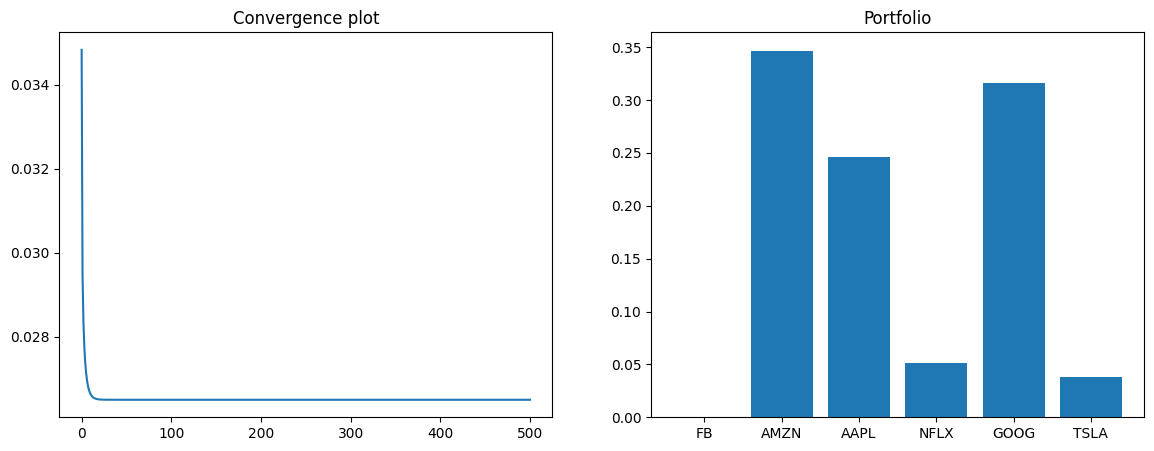

In [9]:
# Data (fictive)
return_vector = np.array([0.249, 0.456, 0.293, 0.429, 0.275, 0.508])
risk_matrix = np.array([[0.101, 0.058, 0.054, 0.06 , 0.057, 0.06 ],
                        [0.058, 0.093, 0.05 , 0.068, 0.053, 0.062],
                        [0.054, 0.05 , 0.087, 0.052, 0.048, 0.064],
                        [0.06 , 0.068, 0.052, 0.178, 0.055, 0.075],
                        [0.057, 0.053, 0.048, 0.055, 0.073, 0.053],
                        [0.06 , 0.062, 0.064, 0.075, 0.053, 0.31 ]])


# 1. Cost function
cost_fun = lambda w : portfolio_objective(w, return_vector, risk_matrix)


# 2. Projection

project = lambda w : project_simplex(w, 1)


# 3. Initialization
init = np.ones(return_vector.size) / (return_vector.size)


# 4. Step-size & Iterations
alpha = 2
epochs = 500


# 5. Optimization
w, history = gradient_descent(cost_fun, init, alpha, epochs, project)


# Visualization
print('Numerical solution:', w)
plt.figure(figsize=(14,5), facecolor='white')
plt.subplot(1,2,1)
plt.plot([cost_fun(u) for u in history])
plt.title('Convergence plot')
plt.subplot(1,2,2)
plt.bar(range(6), w)
plt.xticks(range(6), ["FB", "AMZN", "AAPL", "NFLX", "GOOG", "TSLA"])
plt.title('Portfolio')
plt.show()